# Figure FISH

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
from joblib import Parallel, delayed

import utils as lu
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/analysis5_FISH/utils.py'>

In [2]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of FISH data
dir_fish = '/home/louiscam/projects/gpcr/data/fish_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [3]:
# Load gene to chromosome directory
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)
# Load gene to locus directory
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)

# Load FISH data

### Load genomic scale FISH data
Including for each locus whether the genes measured within it are actively transcribing and the distances from the locus to the nuclear lamina, the nearest nuclear speckle and the nearest nucleolus.

In [4]:
# Load data
merfish_data = pd.read_csv(dir_fish+'dna_merfish_data.tsv', sep='\t', header=0)

In [5]:
# For each cell, determine its nucleus size (maximum probe-probe distance)
merfish_data_reduced = merfish_data[['cell number', 'genomic coordinate', 'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data_reduced = merfish_data_reduced.dropna(how='any', axis=0)
cell_ids = merfish_data_reduced['cell number'].unique()
max_dist_dict = {}
for cell_id in tqdm(cell_ids):
    coords = merfish_data_reduced[merfish_data_reduced['cell number']==cell_id][['x(nm)', 'y(nm)', 'z(nm)']]
    dist = pdist(coords, metric='euclidean')
    max_dist = dist.max()
    max_dist_dict[cell_id] = max_dist

100%|██████████| 3668/3668 [00:43<00:00, 84.62it/s]


In [6]:
# Build dictionary from Ensembl gene name to HGNC
enst2hgnc_df = pd.read_csv(dir_genome+'ensemblGene2Name', sep='\t', header=0)
enst2hgnc_df.columns = ['ENST', 'HGNC']
enst2hgnc_df = enst2hgnc_df.set_index('ENST')
ensg2enst_df = pd.read_csv(dir_genome+'ensemblGene2Transcript2Protein', sep='\t', header=0)
ensg2enst_df.columns = ['ENSG', 'ENST', 'ENSP']
ensg2enst_df = ensg2enst_df[['ENSG', 'ENST']]
ensg2enst_df = ensg2enst_df.set_index('ENST')
ensg2hgnc_df = ensg2enst_df.join(enst2hgnc_df, how='outer').reset_index()
ensg2hgnc_df = ensg2hgnc_df[['ENSG', 'HGNC']].drop_duplicates(['ENSG', 'HGNC'])
ensg2hgnc_df['HGNC'] = ensg2hgnc_df['HGNC'].str.upper()
ensg2hgnc_df = ensg2hgnc_df.reset_index()[['ENSG', 'HGNC']]
ensg2hgnc = {ensg2hgnc_df.loc[i,'ENSG']: ensg2hgnc_df.loc[i,'HGNC'] for i in range(len(ensg2hgnc_df))}

In [7]:
# Add gene information to MERFISH data
merfish_data['gene names'] = merfish_data['gene names'].astype(str)
merfish_data['gene names'] = merfish_data['gene names'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['gene_hgnc'] = merfish_data['gene names'].apply(lambda x: [ensg2hgnc[g] if (g in ensg2hgnc.keys()) 
                                                                    else 'unknown' for g in x] if len(x)>0 else [])
merfish_data['n_genes'] = merfish_data['gene_hgnc'].apply(lambda x: len(x))
merfish_data['transciption'] = merfish_data['transciption'].astype(str)
merfish_data['transciption'] = merfish_data['transciption'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['chrom'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[0]

In [8]:
# Reduce data (drop NAs, chrX and gene-less loci)
merfish_data = merfish_data.dropna(how='any')
merfish_data = merfish_data[merfish_data['chrom']!='chrX']
merfish_data = merfish_data[['cell number',
                             'chrom',
                             'homolog number',
                             'genomic coordinate',
                             'gene_hgnc',
                             'transciption',
                             'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data.columns = [ 'cell_ID',
                         'chrom',
                         'homolog',
                         'probe_locus',
                         'gene_ID',
                         'transcription',
                         'x(nm)', 'y(nm)', 'z(nm)']

In [9]:
# Print basic statistics
print(f'Total number of cells = {len(np.unique(merfish_data["cell_ID"].values))}')
print(f'Total number of loci = {len(np.unique(merfish_data["probe_locus"].values))}')

Total number of cells = 3533
Total number of loci = 990


# Load genes of interest

In [10]:
# Load all adhesome genes
with open(saving_dir+'all_adhesome_genes.pkl', 'rb') as f:
    all_adhesome_genes = pickle.load(f)
# Load active adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Load adhesome TF genes and loci
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)
active_adhesome_genes = np.concatenate([active_adhesome_genes, active_lung_adhesome_tf_genes])

In [11]:
# Sample random non-adhesome active genes
with open(saving_dir+'all_active_genes.pkl', 'rb') as f:
    all_active_genes = pickle.load(f)
with open(saving_dir+'all_inactive_genes.pkl', 'rb') as f:
    all_inactive_genes = pickle.load(f)
active_gene_pool = list(set(all_active_genes)-set(active_adhesome_genes))
active_gene_pool = np.array(active_gene_pool)
random_active_genes = active_gene_pool

In [12]:
# Genes for downstream analysis
selected_genes = np.concatenate([active_adhesome_genes, random_active_genes])
print(f'Number of selected genes = {len(selected_genes)}')

Number of selected genes = 22595


In [13]:
# Location of genes in hg38

df_loc = pd.read_csv(dir_genome+'chrom_hg38.loc', sep='\t', header=0)
df_loc = df_loc[df_loc['#chrom'].isin(['chr'+str(i) for i in range(1,23)])]
df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneName']]
df_loc.columns = ['chrom', 'start', 'end', 'geneName']
df_loc = df_loc.sort_values(['chrom','start','end'])
df_loc = df_loc.groupby(['chrom','geneName']).agg({'start':'min', 'end':'max'})
df_loc = df_loc.reset_index().sort_values(['chrom','start','end'])

# Detect genes that are present on multiple chromosomes and drop them
n_chroms_per_gene = df_loc.groupby('geneName')['chrom'].size()
n_chroms_per_gene = n_chroms_per_gene[n_chroms_per_gene>1]
genes2drop = n_chroms_per_gene.index.values
df_loc = df_loc[~df_loc['geneName'].isin(genes2drop)]

# Restrict location dataframe to adhesome specifically
df_loc_adhesome = df_loc[df_loc['geneName'].isin(selected_genes)]

In [14]:
# Identify adhesome genes present within 1kb of available MERFISH probes
resol = 0

In [15]:
# Construct a bed object for adhesome genes
df_adhesome_pos = df_loc_adhesome[['chrom','start','end', 'geneName']]
bed_adhesome = pybedtools.BedTool.from_dataframe(df_adhesome_pos).sort()
bed_adhesome_df = bed_adhesome.to_dataframe()

In [16]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos['start'] = (df_merfish_pos['start']-resol).clip(lower=0)
df_merfish_pos['end'] = (df_merfish_pos['end']+resol)
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [17]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_adhesome, c=[4], o='distinct')
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
counts['adhesome'] = [[g for g in gene_list if g in active_adhesome_genes] for gene_list in counts['score']]
counts['n_adhesome'] = [len(ls) for ls in counts['adhesome']]
counts['non_adhesome'] = [[g for g in gene_list if g in random_active_genes] for gene_list in counts['score']]
counts['n_non_adhesome'] = [len(ls) for ls in counts['non_adhesome']]
merfishloc2gene = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

In [18]:
# Create gene2merfishloc mapping
gene2merfishloc = defaultdict(list)
for k, v in merfishloc2gene.items():
    if len(v)>0:
        for g in v:
            gene2merfishloc[g].append(k)
gene2merfishloc = dict(gene2merfishloc)

In [19]:
# Basic stats
print(f'Coverage of active adhesome genes by MERFISH probes = {len(list(itertools.chain.from_iterable(counts["adhesome"].values)))}')
print(f'Coverage of active non-adhesome genes by MERFISH probes = {len(list(itertools.chain.from_iterable(counts["non_adhesome"].values)))}')
print(f'Number of MERFISH probes covering active adhesome loci = {counts[counts["n_adhesome"]>0].shape[0]}')
print(f'Number of MERFISH probes covering active non-adhesome loci = {counts[counts["n_non_adhesome"]>0].shape[0]}')

Coverage of active adhesome genes by MERFISH probes = 19
Coverage of active non-adhesome genes by MERFISH probes = 1005
Number of MERFISH probes covering active adhesome loci = 19
Number of MERFISH probes covering active non-adhesome loci = 538


In [20]:
# Identify MERFISH loci of adhesome genes
adh_merfish_loc = counts[counts["n_adhesome"]>0]['name'].values

# Identify MERFISH loci of random genes
rand_merfish_loc = counts[counts["n_non_adhesome"]>0]['name'].values
rand_merfish_loc = np.array(list(set(rand_merfish_loc)-set(adh_merfish_loc)))

# Combine adh_merfish_loc and rand_merfish_loc
selected_merfish_loc = np.concatenate([adh_merfish_loc, rand_merfish_loc])

# Compare MERFISH distances between adhesome loci and random loci all non-adhesome active loci

In [21]:
# Select MERFISH data corresponding to active adhesome genes and active random genes
selected_merfish_data = merfish_data.copy()
selected_merfish_data = selected_merfish_data.loc[selected_merfish_data['probe_locus'].isin(selected_merfish_loc),:]

In [22]:
# A few statistics
all_merfish_loci = np.unique(selected_merfish_data["probe_locus"])
all_merfish_cells = np.unique(selected_merfish_data["cell_ID"])
print(f'Number of unique loci = {len(all_merfish_loci)}')
print(f'Number of unique cells = {len(all_merfish_cells)}')

Number of unique loci = 547
Number of unique cells = 3533


In [23]:
# Build a dictionary where for each cell, we report a gene by gene distance matrix between adhesome genes
cell2distmat = {}
for cell in tqdm(all_merfish_cells):
    cell_data = selected_merfish_data.loc[selected_merfish_data['cell_ID']==cell,
                                          ['x(nm)','y(nm)','z(nm)','probe_locus']]
    cell_data = cell_data.groupby('probe_locus').agg({'x(nm)': 'mean', 'y(nm)': 'mean', 'z(nm)': 'mean'})
    dist_mat = squareform(pdist(cell_data, metric='euclidean'))/max_dist_dict[cell]
    cell2distmat[cell] = pd.DataFrame(dist_mat,columns = cell_data.index.values, index = cell_data.index.values)

100%|██████████| 3533/3533 [00:24<00:00, 142.51it/s]


In [24]:
# Combine information across all cells into one dataframe
distances_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
n_samples_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
for cell in tqdm(all_merfish_cells):
    cell_dist_mat = cell2distmat[cell]
    cell_idx = cell_dist_mat.index.values
    distances_df.loc[cell_idx, cell_idx] += cell_dist_mat
    n_samples_df.loc[cell_idx, cell_idx] += 1 
n_samples_df = n_samples_df.replace(0, np.nan)

100%|██████████| 3533/3533 [00:44<00:00, 78.84it/s]


In [25]:
# Average distance dataframe
avg_dist_df = distances_df/n_samples_df
print(f'Maximum average distance = {avg_dist_df.max().max()}')
avg_prox_df = 1-avg_dist_df

Maximum average distance = 0.3805029723765134


In [26]:
# Procedure to sort final_adh_loc and final_rand_loc in genomic order
sort_adh = pd.DataFrame({'locus': adh_merfish_loc})
sort_adh['chrom'] = sort_adh['locus'].str.split(':', expand=True)[0]
sort_adh['chrom'] = sort_adh['chrom'].str.split('chr', expand=True)[1].astype(int)
sort_adh['ext'] = sort_adh['locus'].str.split(':', expand=True)[1]
sort_adh['start'] = sort_adh['ext'].str.split('-', expand=True)[0].astype(int)
sort_adh['end'] = sort_adh['ext'].str.split('-', expand=True)[1].astype(int)
sort_adh = sort_adh[['locus','chrom','start','end']]
sort_adh = sort_adh.sort_values(['chrom','start','end'])
final_adh_loc =  sort_adh['locus'].values
sort_rand = pd.DataFrame({'locus': rand_merfish_loc})
sort_rand['chrom'] = sort_rand['locus'].str.split(':', expand=True)[0]
sort_rand['chrom'] = sort_rand['chrom'].str.split('chr', expand=True)[1].astype(int)
sort_rand['ext'] = sort_rand['locus'].str.split(':', expand=True)[1]
sort_rand['start'] = sort_rand['ext'].str.split('-', expand=True)[0].astype(int)
sort_rand['end'] = sort_rand['ext'].str.split('-', expand=True)[1].astype(int)
sort_rand = sort_rand[['locus','chrom','start','end']]
sort_rand = sort_rand.sort_values(['chrom','start','end'])
final_rand_loc =  sort_rand['locus'].values

In [27]:
# Create stacked version of avg_dist_df with metadata on each edge

avg_dist_df_stacked = avg_dist_df.stack().to_frame('distance').reset_index()
avg_dist_df_stacked.columns = ['probe1', 'probe2', 'distance']
# Edge type
avg_dist_df_stacked['Type'] = avg_dist_df_stacked.apply(
    lambda row: 'intrachromosomal' if (row['probe1'].split(':')[0]==row['probe2'].split(':')[0]) 
    else'interchromosomal',
    axis=1
)
# Edge group
avg_dist_df_stacked['Group'] = avg_dist_df_stacked.apply(
    lambda row: 'Active adhesome loci' if ((row['probe1'] in final_adh_loc) & (row['probe2'] in final_adh_loc)) 
    else ('All active non-adhesome loci' if ((row['probe1'] in final_rand_loc) & (row['probe2'] in final_rand_loc)) 
         else ''),
    axis=1
)
avg_dist_df_stacked = avg_dist_df_stacked[avg_dist_df_stacked['Group']!='']
# Drop self edges
avg_dist_df_stacked = avg_dist_df_stacked[avg_dist_df_stacked['probe1']!=avg_dist_df_stacked['probe2']]

In [28]:
# Create stacked version of avg_prox_df with metadata on each edge

avg_prox_df_stacked = avg_prox_df.stack().to_frame('proximity').reset_index()
avg_prox_df_stacked.columns = ['probe1', 'probe2', 'proximity']
# Edge type
avg_prox_df_stacked['Type'] = avg_prox_df_stacked.apply(
    lambda row: 'intrachromosomal' if (row['probe1'].split(':')[0]==row['probe2'].split(':')[0]) 
    else'interchromosomal',
    axis=1
)
# Edge group
avg_prox_df_stacked['Group'] = avg_prox_df_stacked.apply(
    lambda row: 'Active adhesome loci' if ((row['probe1'] in final_adh_loc) & (row['probe2'] in final_adh_loc)) 
    else ('All active non-adhesome loci' if ((row['probe1'] in final_rand_loc) & (row['probe2'] in final_rand_loc)) 
         else ''),
    axis=1
)
avg_prox_df_stacked = avg_prox_df_stacked[avg_prox_df_stacked['Group']!='']
# Drop self edges
avg_prox_df_stacked = avg_prox_df_stacked[avg_prox_df_stacked['probe1']!=avg_prox_df_stacked['probe2']]

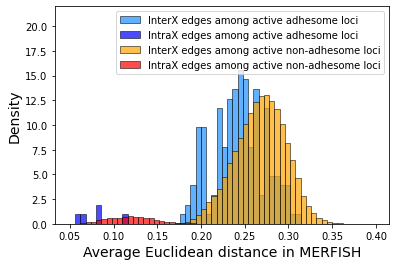

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-8.840373664624433, pvalue=9.539900512232384e-19)


In [31]:
# Plot histogram of MERFISH distances
f, ax = plt.subplots()
palette ={"interchromosomal": "dodgerblue", "intrachromosomal": "blue"}
sns.histplot(data=avg_dist_df_stacked[avg_dist_df_stacked['Group']=='Active adhesome loci'], 
             x='distance', 
             hue='Type',
             palette=palette,
             alpha=0.7, 
             stat='density',
             common_norm=True,
             bins=np.arange(0.05, 0.4, 0.006),
             legend=False,
             ax=ax)
# sns.move_legend(ax, "lower right")
palette ={"interchromosomal": "orange", "intrachromosomal": "red"}
ax = sns.histplot(data=avg_dist_df_stacked[avg_dist_df_stacked['Group']=='All active non-adhesome loci'], 
             x='distance', 
             hue='Type',
             palette=palette,
             alpha=0.7, 
             stat='density',
             common_norm=True,
             bins=np.arange(0.05, 0.4, 0.006),
             label='All active non-adhesome loci',
             ax=ax)
ax.legend([
    'InterX edges among active adhesome loci', 
    'IntraX edges among active adhesome loci', 
    'InterX edges among active non-adhesome loci',
    'IntraX edges among active non-adhesome loci'])
plt.ylim([0, 22])
plt.xlabel('Average Euclidean distance in MERFISH', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'supp_fig_18.pdf', format='pdf', bbox_inches = 'tight')
plt.show()
# Wilcoxon Rank-Sums test
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(
    avg_dist_df.loc[adh_merfish_loc, adh_merfish_loc].values[np.triu_indices(len(adh_merfish_loc),1)],
    avg_dist_df.loc[rand_merfish_loc, rand_merfish_loc].values[np.triu_indices(len(rand_merfish_loc),1)]
))

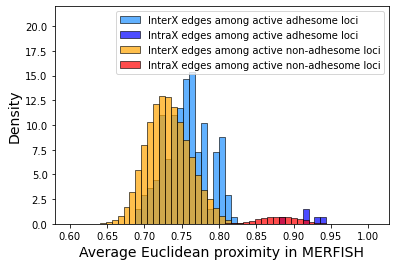

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=8.840373664624433, pvalue=9.539900512232384e-19)


In [53]:
# Plot histogram of MERFISH proximity
f, ax = plt.subplots()
palette ={"interchromosomal": "dodgerblue", "intrachromosomal": "blue"}
sns.histplot(data=avg_prox_df_stacked[avg_prox_df_stacked['Group']=='Active adhesome loci'], 
             x='proximity', 
             hue='Type',
             palette=palette,
             alpha=0.7, 
             stat='density',
             common_norm=True,
             bins=np.arange(0.6, 1.01, 0.008),
             legend=False,
             ax=ax)
# sns.move_legend(ax, "lower right")
palette ={"interchromosomal": "orange", "intrachromosomal": "red"}
ax = sns.histplot(data=avg_prox_df_stacked[avg_prox_df_stacked['Group']=='All active non-adhesome loci'], 
             x='proximity', 
             hue='Type',
             palette=palette,
             alpha=0.7, 
             stat='density',
             common_norm=True,
             bins=np.arange(0.6, 1.01, 0.008),
             label='All active non-adhesome loci',
             ax=ax)
ax.legend([
    'InterX edges among active adhesome loci', 
    'IntraX edges among active adhesome loci', 
    'InterX edges among active non-adhesome loci',
    'IntraX edges among active non-adhesome loci'])
plt.ylim([0, 22])
plt.xlabel('Average Euclidean proximity in MERFISH', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.legend(loc='upper right')
plt.show()
# Wilcoxon Rank-Sums test
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(
    avg_prox_df.loc[adh_merfish_loc, adh_merfish_loc].values[np.triu_indices(len(adh_merfish_loc),1)],
    avg_prox_df.loc[rand_merfish_loc, rand_merfish_loc].values[np.triu_indices(len(rand_merfish_loc),1)]
))